##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fitting Dirichlet Process Mixture Model Using Preconditioned Stochastic Gradient Langevin Dynamics
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Fitting_DPMM_Using_pSGLD"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this notebook, we will demonstrate how to cluster a large number of samples and infer the number of clusters simultaneously by fitting a Dirichlet Process Mixture of Gaussian distribution. We use Preconditioned Stochastic Gradient Langevin Dynamics (pSGLD) for inference. 

## Table of contents

1. Samples

1. Model

1. Optimization

1. Visualize the result

  4.1. Clustered result

  4.2. Visualize uncertainty
  
  4.3. Mean and scale of selected mixture component
  
  4.4. Mixture weight of each mixture component
  
  4.5. Convergence of $\alpha$
  
  4.6. Inferred number of clusters over iterations
  
  4.7. Fitting the model using RMSProp

1. Conclusion

---


## 1. Samples

First, we set up a toy dataset. We generate 50,000 random samples from three bivariate Gaussian distributions.

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

In [0]:
plt.style.use('ggplot')
tfd = tfp.distributions

In [0]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

In [0]:
# For reproducibility
rng = np.random.RandomState(seed=45)
tf.set_random_seed(76)

# Precision
dtype = np.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]
                + rng.randn(num_samples, dims).astype(dtype))

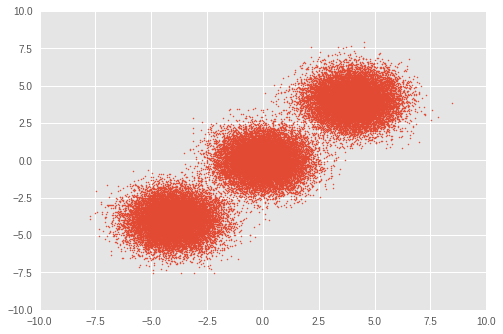

In [0]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

## 2. Model

Here, we define a Dirichlet Process Mixture of Gaussian distribution with Symmetric Dirichlet Prior. Throughout the notebook, vector quantities are written in bold. Over  $i\in\{1,\ldots,N\}$ samples, the model with a mixture of $j \in\{1,\ldots,K\}$ Gaussian distributions is formulated as follow:

$$\begin{align*}
p(\boldsymbol{x}_1,\cdots, \boldsymbol{x}_N) &=\prod_{i=1}^N \text{GMM}(x_i), \\
&\,\quad \text{with}\;\text{GMM}(x_i)=\sum_{j=1}^K\pi_j\text{Normal}(x_i\,|\,\text{loc}=\boldsymbol{\mu_{j}},\,\text{scale}=\boldsymbol{\sigma_{j}})\\ 
\end{align*}$$
where:

$$\begin{align*}
x_i&\sim \text{Normal}(\text{loc}=\boldsymbol{\mu}_{z_i},\,\text{scale}=\boldsymbol{\sigma}_{z_i}) \\
z_i &= \text{Categorical}(\text{prob}=\boldsymbol{\pi}),\\
&\,\quad \text{with}\;\boldsymbol{\pi}=\{\pi_1,\cdots,\pi_K\}\\
\boldsymbol{\pi}&\sim\text{Dirichlet}(\text{concentration}=\{\frac{\alpha}{K},\cdots,\frac{\alpha}{K}\})\\
\alpha&\sim \text{InverseGamma}(\text{concentration}=1,\,\text{rate}=1)\\
\boldsymbol{\mu_j} &\sim \text{Normal}(\text{loc}=\boldsymbol{0}, \,\text{scale}=\boldsymbol{1})\\
\boldsymbol{\sigma_j} &\sim \text{InverseGamma}(\text{concentration}=\boldsymbol{1},\,\text{rate}=\boldsymbol{1})\\
\end{align*}$$

Our goal is to assign each $x_i$ to the $j$th cluster through $z_i$ which represents the inferred index of a cluster.

For an ideal Dirichlet Mixture Model, $K$ is set to $\infty$. However, it is known that one can approximate a Dirichlet Mixture Model with a sufficiently large $K$. Note that although we arbitrarily set an initial value of $K$, an optimal number of clusters is also inferred through optimization,  unlike a simple Gaussian Mixture Model.

In this notebook, we use a bivariate Gaussian distribution as a mixture component and set $K$ to 30.

In [0]:
reset_sess()

# Upperbound on K
max_cluster_num = 30

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.Variable(
        name='mix_probs',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc = tf.Variable(
    name='loc',
    initial_value=np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision = tf.nn.softplus(tf.Variable(
    name='precision',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.Variable(
    name='alpha',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype) * alpha / max_cluster_num,
    name='rv_sdp')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))

## 3. Optimization


We optimize the model with Preconditioned Stochastic Gradient Langevin Dynamics (pSGLD), which enables us to optimize a model over a large number of samples in a mini-batch gradient descent manner. 

To update parameters $\boldsymbol{\theta}\equiv\{\boldsymbol{\pi},\,\alpha,\, \boldsymbol{\mu_j},\,\boldsymbol{\sigma_j}\}$ in $t\,$th iteration with mini-batch size $M$, the update is sampled as:

$$\begin{align*}
\Delta \boldsymbol { \theta } _ { t } & \sim \frac { \epsilon _ { t } } { 2 } \bigl[ G \left( \boldsymbol { \theta } _ { t } \right) \bigl( \nabla _ { \boldsymbol { \theta } } \log p \left( \boldsymbol { \theta } _ { t } \right) 
 + \frac { N } { M } \sum _ { k = 1 } ^ { M } \nabla _ \boldsymbol { \theta } \log \text{GMM}(x_{t_k})\bigr) + \sum_\boldsymbol{\theta}\nabla_\theta G \left( \boldsymbol { \theta } _ { t } \right) \bigr]\\
&+ G ^ { \frac { 1 } { 2 } } \left( \boldsymbol { \theta } _ { t } \right) \text { Normal } \left( \text{loc}=\boldsymbol{0} ,\, \text{scale}=\epsilon _ { t }\boldsymbol{1} \right)\\
\end{align*}$$

In the above equation, $\epsilon _ { t }$ is learning rate at $t\,$th iteration and $\log p(\theta_t)$ is a sum of log prior distributions of $\theta$. $G ( \boldsymbol { \theta } _ { t })$ is a preconditioner which adjusts the scale of the gradient of each parameter. 


In [0]:
# Learning rates and decay
starter_learning_rate = 1e-6
end_learning_rate = 1e-10
decay_steps = 1e4

# Number of training steps
training_steps = 10000

# Mini-batch size
batch_size = 20

# Sample size for parameter posteriors
sample_size = 100

We will use the joint log probability of the likelihood $\text{GMM}(x_{t_k})$ and the prior probabilities $p(\theta_t)$ as the loss function for pSGLD.

Note that as specified in the [API of pSGLD](https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics), we need to divide the sum of the prior probabilities by sample size $N$. 

In [0]:
# Placeholder for mini-batch
observations_tensor = tf.compat.v1.placeholder(dtype, shape=[batch_size, dims])

# Define joint log probabilities
# Notice that each prior probability should be divided by num_samples and
# likelihood is divided by batch_size for pSGLD optimization.
log_prob_parts = [
    rv_loc.log_prob(loc) / num_samples,
    rv_precision.log_prob(precision) / num_samples,
    rv_alpha.log_prob(alpha) / num_samples,
    rv_symmetric_dirichlet_process.log_prob(mix_probs)[..., tf.newaxis]
    / num_samples,
    rv_observations.log_prob(observations_tensor) / batch_size
]
joint_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)

In [0]:
# Make mini-batch generator
dx = tf.compat.v1.data.Dataset.from_tensor_slices(observations)\
  .shuffle(500).repeat().batch(batch_size)
iterator = tf.compat.v1.data.make_one_shot_iterator(dx)
next_batch = iterator.get_next()

# Define learning rate scheduling
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate,
    global_step, decay_steps,
    end_learning_rate, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
    learning_rate=learning_rate,
    preconditioner_decay_rate=0.99,
    burnin=1500,
    data_size=num_samples)

train_op = optimizer_kernel.minimize(-joint_log_prob)

# Arrays to store samples
mean_mix_probs_mtx = np.zeros([training_steps, max_cluster_num])
mean_alpha_mtx = np.zeros([training_steps, 1])
mean_loc_mtx = np.zeros([training_steps, max_cluster_num, dims])
mean_precision_mtx = np.zeros([training_steps, max_cluster_num, dims])

init = tf.global_variables_initializer()
sess.run(init)

start = time.time()
for it in range(training_steps):
  [
      mean_mix_probs_mtx[it, :],
      mean_alpha_mtx[it, 0],
      mean_loc_mtx[it, :, :],
      mean_precision_mtx[it, :, :],
      _
  ] = sess.run([
      *training_vals,
      train_op
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_psgld = time.time() - start
print("Elapsed time: {} seconds".format(elapsed_time_psgld))

# Take mean over the last sample_size iterations
mean_mix_probs_ = mean_mix_probs_mtx[-sample_size:, :].mean(axis=0)
mean_alpha_ = mean_alpha_mtx[-sample_size:, :].mean(axis=0)
mean_loc_ = mean_loc_mtx[-sample_size:, :].mean(axis=0)
mean_precision_ = mean_precision_mtx[-sample_size:, :].mean(axis=0)

Elapsed time: 309.8013095855713 seconds


## 4. Visualize the result

### 4.1. Clustered result

First, we visualize the result of clustering.


For assigning each sample $x_i$ to a cluster $j$, we calculate the posterior of $z_i$ as:

$$\begin{align*}
j =  \underset{z_i}{\arg\max}\,p(z_i\,|\,x_i,\,\boldsymbol{\theta})
\end{align*}$$

Number of inferred clusters = 3

Number of elements in each cluster = [16911 16645 16444]



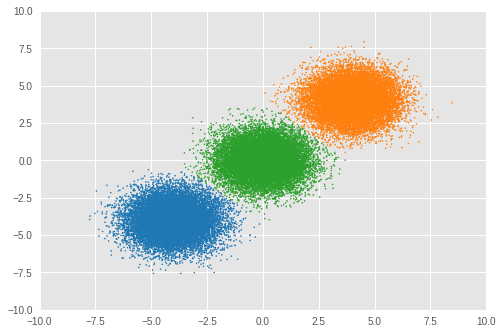

In [0]:
loc_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='loc_for_posterior')
precision_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='precision_for_posterior')
mix_probs_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num], name='mix_probs_for_posterior')

# Posterior of z (unnormalized)
unnomarlized_posterior = tfd.MultivariateNormalDiag(
    loc=loc_for_posterior, scale_diag=precision_for_posterior)\
   .log_prob(tf.expand_dims(tf.expand_dims(observations, axis=1), axis=1))\
   + tf.log(mix_probs_for_posterior[tf.newaxis, ...])

# Posterior of z (normarizad over latent states)
posterior = unnomarlized_posterior\
  - tf.reduce_logsumexp(unnomarlized_posterior, axis=-1)[..., tf.newaxis]

cluster_asgmt = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: mean_loc_mtx[-sample_size:, :],
        precision_for_posterior: mean_precision_mtx[-sample_size:, :],
        mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]})

idxs, count = np.unique(cluster_asgmt, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_asgmt)))
plt.axis([-10, 10, -10, 10])
plt.show()

We can see an almost equal number of samples are assigned to appropriate clusters and the model has successfully inferred the correct number of clusters as well.


### 4.2. Visualize uncertainty

Here, we look at the uncertainty of the clustering result by visualizing it for each sample.

We calculate uncertainty by using entropy:

$$\begin{align*}
\text{Uncertainty}_\text{entropy} =  -\frac{1}{K}\sum^{K}_{z_i=1}\sum^{O}_{l=1}p(z_i\,|\,x_i,\,\boldsymbol{\theta}_l)\log p(z_i\,|\,x_i,\,\boldsymbol{\theta}_l)
\end{align*}$$

In pSGLD, we treat the value of a training parameter at each iteration as a sample from its posterior distribution. Thus, we calculate entropy over values from $O$ iterations for each parameter. The final entropy value is calculated by averaging entropies of all the cluster assignments.

In [0]:
# Calculate entropy
posterior_in_exponential = tf.exp(posterior)
uncertainty_in_entropy = tf.reduce_mean(-tf.reduce_sum(
    posterior_in_exponential
    * posterior,
    axis=1), axis=1)

uncertainty_in_entropy_ = sess.run(uncertainty_in_entropy, feed_dict={
    loc_for_posterior: mean_loc_mtx[-sample_size:, :],
    precision_for_posterior: mean_precision_mtx[-sample_size:, :],
    mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]
})

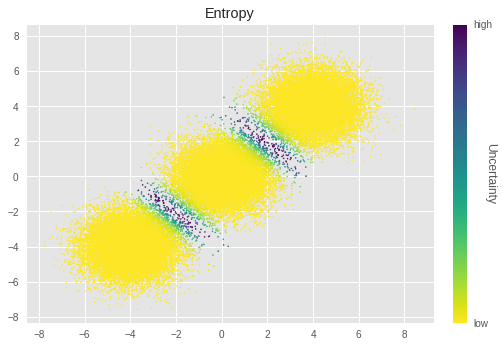

In [0]:
plt.title('Entropy')
sc = plt.scatter(observations[:, 0],
                 observations[:, 1],
                 1,
                 c=uncertainty_in_entropy_,
                 cmap=plt.cm.viridis_r)
cbar = plt.colorbar(sc,
                    fraction=0.046,
                    pad=0.04,
                    ticks=[uncertainty_in_entropy_.min(),
                           uncertainty_in_entropy_.max()])
cbar.ax.set_yticklabels(['low', 'high'])
cbar.set_label('Uncertainty', rotation=270)
plt.show()

In the above graph, less luminance represents more uncertainty. 
We can see the samples near the boundaries of the clusters have especially higher uncertainty. This is intuitively true, that those samples are difficult to cluster.

### 4.3. Mean and scale of selected mixture component

Next, we look at selected clusters' $\mu_j$ and $\sigma_j$.

In [0]:
for idx, numbe_of_samples in zip(idxs, count):
  print(
      'Component id = {}, Number of elements = {}'
      .format(idx, numbe_of_samples))
  print(
      'Mean loc = {}, Mean scale = {}\n'
      .format(mean_loc_[idx, :], mean_precision_[idx, :]))

Component id = 0, Number of elements = 16911
Mean loc = [-4.030 -4.113], Mean scale = [ 0.994  0.972]

Component id = 4, Number of elements = 16645
Mean loc = [ 3.999  4.069], Mean scale = [ 1.038  1.046]

Component id = 5, Number of elements = 16444
Mean loc = [-0.005 -0.023], Mean scale = [ 0.967  1.025]



Again, the $\boldsymbol{\mu_j}$ and $\boldsymbol{\sigma_j}$ close to the ground truth.

### 4.4 Mixture weight of each mixture component

We also look at inferred mixture weights.

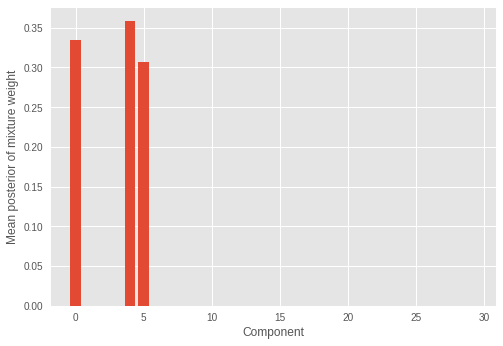

In [0]:
plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

We see only a few (three) mixture component have significant weights and the rest of the weights have values close to zero. This also shows the model successfully inferred the correct number of mixture components which constitutes the distribution of the samples.

### 4.5. Convergence of $\alpha$

We look at convergence of Dirichlet distribution's concentration parameter $\alpha$.

Value of inferred alpha = 0.679



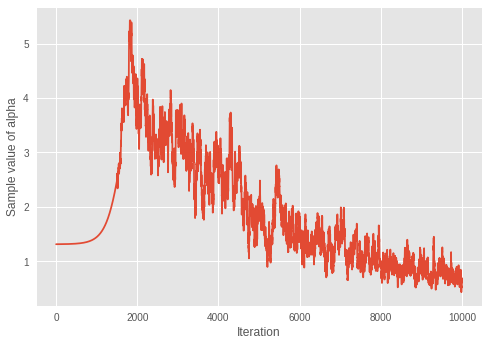

In [0]:
print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))
plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(mean_alpha_mtx)
plt.show()

Considering the fact that smaller $\alpha$ results in less expected number of clusters in a Dirichlet mixture model, the model seems to be learning the optimal number of clusters over iterations.

### 4.6. Inferred number of clusters over iterations

We visualize how the inferred number of clusters changes over iterations.

To do so, we infer the number of clusters over the iterations.

In [0]:
step = sample_size
num_of_iterations = 50
estimated_num_of_clusters = []
interval = (training_steps - step) // (num_of_iterations - 1)
iterations = np.asarray(range(step, training_steps+1, interval))
for iteration in iterations:
  start_position = iteration-step
  end_position = iteration

  result = sess.run(tf.argmax(
      tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
          loc_for_posterior:
              mean_loc_mtx[start_position:end_position, :],
          precision_for_posterior:
              mean_precision_mtx[start_position:end_position, :],
          mix_probs_for_posterior:
              mean_mix_probs_mtx[start_position:end_position, :]})

  idxs, count = np.unique(result, return_counts=True)
  estimated_num_of_clusters.append(len(count))

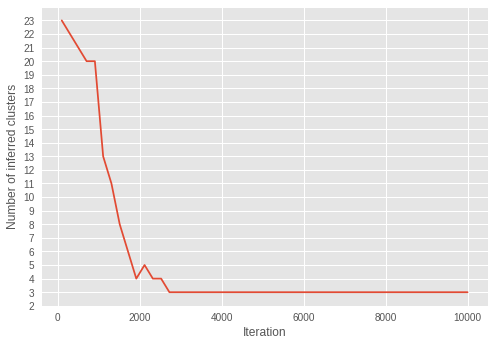

In [0]:
plt.ylabel('Number of inferred clusters')
plt.xlabel('Iteration')
plt.yticks(np.arange(1, max(estimated_num_of_clusters) + 1, 1))
plt.plot(iterations - 1, estimated_num_of_clusters)
plt.show()

Over the iterations, the number of clusters is getting closer to three. With the result of convergence of $\alpha$ to smaller value over iterations, we can see the model is successfully learning the parameters to infer an optimal number of clusters.

Interestingly, we can see the inference has already converged to the correct number of clusters in the early iterations, unlike $\alpha$ converged in much later iterations. 


### 4.7. Fitting the model using RMSProp 

In this section, to see the effectiveness of Monte Carlo sampling scheme of pSGLD, we use RMSProp to fit the model. We choose RMSProp for comparison because it comes without the sampling scheme and pSGLD is based on RMSProp.


In [0]:
# Learning rates and decay
starter_learning_rate_rmsprop = 1e-2
end_learning_rate_rmsprop = 1e-4
decay_steps_rmsprop = 1e4

# Number of training steps
training_steps_rmsprop = 50000

# Mini-batch size
batch_size_rmsprop = 20

In [0]:
# Define trainable variables.
mix_probs_rmsprop = tf.nn.softmax(
    tf.Variable(
        name='mix_probs_rmsprop',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc_rmsprop = tf.Variable(
    name='loc_rmsprop',
    initial_value=np.zeros([max_cluster_num, dims], dtype)
    + np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision_rmsprop = tf.nn.softplus(tf.Variable(
    name='precision_rmsprop',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha_rmsprop = tf.nn.softplus(tf.Variable(
    name='alpha_rmsprop',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals_rmsprop =\
    [mix_probs_rmsprop, alpha_rmsprop, loc_rmsprop, precision_rmsprop]

# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process_rmsprop = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype)
    * alpha_rmsprop / max_cluster_num,
    name='rv_sdp_rmsprop')

rv_loc_rmsprop = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc_rmsprop')


rv_precision_rmsprop = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision_rmsprop')

rv_alpha_rmsprop = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha_rmsprop')

# Define mixture model
rv_observations_rmsprop = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs_rmsprop),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc_rmsprop,
        scale_diag=precision_rmsprop))

In [0]:
og_prob_parts_rmsprop = [
    rv_loc_rmsprop.log_prob(loc_rmsprop),
    rv_precision_rmsprop.log_prob(precision_rmsprop),
    rv_alpha_rmsprop.log_prob(alpha_rmsprop),
    rv_symmetric_dirichlet_process_rmsprop
        .log_prob(mix_probs_rmsprop)[..., tf.newaxis],
    rv_observations_rmsprop.log_prob(observations_tensor)
    * num_samples / batch_size
]
joint_log_prob_rmsprop = tf.reduce_sum(
    tf.concat(log_prob_parts_rmsprop, axis=-1), axis=-1)

In [0]:
# Define learning rate scheduling
global_step_rmsprop = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate_rmsprop,
    global_step_rmsprop, decay_steps_rmsprop,
    end_learning_rate_rmsprop, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel_rmsprop = tf.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.99)

train_op_rmsprop = optimizer_kernel_rmsprop.minimize(-joint_log_prob_rmsprop)

init_rmsprop = tf.global_variables_initializer()
sess.run(init_rmsprop)

start = time.time()
for it in range(training_steps_rmsprop):
  [
      _
  ] = sess.run([
      train_op_rmsprop
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_rmsprop = time.time() - start
print("RMSProp elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_rmsprop, training_steps_rmsprop))
print("pSGLD elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_psgld, training_steps))

mix_probs_rmsprop_, alpha_rmsprop_, loc_rmsprop_, precision_rmsprop_ =\
  sess.run(training_vals_rmsprop)

RMSProp elapsed_time: 53.7574200630188 seconds (50000 iterations)
pSGLD elapsed_time: 309.8013095855713 seconds (10000 iterations)


Compare to pSGLD, although the number of iterations for RMSProp is longer, optimization by RMSProp is much faster.

Next, we look at the clustering result.

Number of inferred clusters = 4

Number of elements in each cluster = [ 1644 15267 16647 16442]



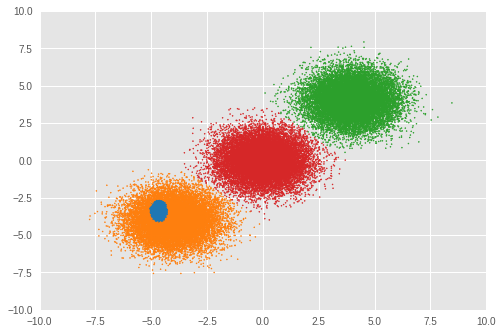

In [0]:
cluster_asgmt_rmsprop = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: loc_rmsprop_[tf.newaxis, :],
        precision_for_posterior: precision_rmsprop_[tf.newaxis, :],
        mix_probs_for_posterior: mix_probs_rmsprop_[tf.newaxis, :]})

idxs, count = np.unique(cluster_asgmt_rmsprop, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(
        cluster_asgmt_rmsprop)))
plt.axis([-10, 10, -10, 10])
plt.show()

The number of clusters was not correctly inferred by RMSProp optimization in our experiment. We also look at the mixture weight.

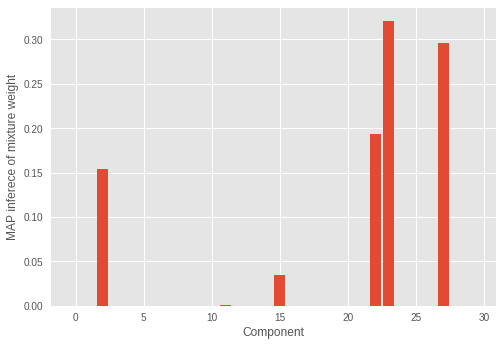

In [0]:
plt.ylabel('MAP inferece of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mix_probs_rmsprop_)
plt.show()

We can see the incorrect number of components have significant mixture weights.

Although the optimization takes longer time, pSGLD, which has Monte Carlo sampling scheme, performed better in our experiment.

## 5. Conclusion

In this notebook, we have described how to cluster a large number of samples as well as to infer the number of clusters simultaneously by fitting a Dirichlet Process Mixture of Gaussian distribution using pSGLD.

The experiment has shown the model successfully clustered samples and inferred the correct number of clusters. Also, we have shown the Monte Carlo sampling scheme of pSGLD allows us to visualize uncertainty in the result. Not only clustering the samples but also we have seen the model could infer the correct parameters of mixture components. On the relationship between the parameters and the number of inferred clusters, we have investigated how the model learns the parameter to control the number of effective clusters by visualizing the correlation between convergence of 𝛼 and the number of inferred clusters. Lastly, we have looked at the results of fitting the model using RMSProp. We have seen RMSProp, which is the optimizer without Monte Carlo sampling scheme,  works considerably faster than pSGLD but has produced less accuracy in clustering.

Although the toy dataset only had 50,000 samples with only two dimensions, the mini-batch manner optimization used here is scalable for much larger datasets.